In [54]:
import torch
import torch.utils.data as Data
from datasets import load_from_disk
from transformers import BertTokenizer, BertModel
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score
import copy
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import random
import math

In [55]:
dataset = load_from_disk('seamew_ChnSentiCorp/')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
})

In [56]:
class CFG:
    seed = 42
    epochs = 5
    model_name = "bert-base-chinese"
    verbose = 100
    batch_size = 16
    
    num_warmup_steps = 0
    num_training_steps = math.ceil(len(dataset['train']) / batch_size) * epochs  # 向上取整

In [57]:
def set_seed(seed):
    """PyTorch随机数种子设置大全"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)  # CPU上设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 当前GPU上设置随机种子
        # A bool that, if True, causes cuDNN to only use deterministic convolution algorithms.
        torch.backends.cudnn.deterministic = True
        # torch.cuda.manual_seed_all(seed) # 所有GPU上设置随机种子


set_seed(CFG.seed)

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [59]:
class Dataset(Data.Dataset):
    """定义数据集"""

    def __init__(self, data, split):
        self.dataset = data[split]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        """定义索引方式"""
        text = self.dataset[i]['text']
        label = self.dataset[i]['label']
        return text, label


dataset_train = Dataset(dataset, 'train')  # torch.utils.data.Dataset

for text, label in dataset_train:
    # 调用__getitem__方法
    print(text)
    print(label)
    break

选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般
1


In [60]:
tokenizer = BertTokenizer.from_pretrained(CFG.model_name)
print(tokenizer.model_input_names)
print(tokenizer)

pretrained = BertModel.from_pretrained(CFG.model_name)
print(pretrained.num_parameters())

['input_ids', 'token_type_ids', 'attention_mask']
BertTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


102267648


In [61]:
def get_collate_fn(tokenizer, max_len=512):
    """返回collate_fun函数(通过闭包函数引入形参)"""

    def collate_fn(data):
        sents = [i[0] for i in data]
        labels = [i[1] for i in data]

        # 批量编码句子
        text_t = tokenizer(text=sents,
                           truncation=True,
                           padding='max_length',
                           max_length=max_len,
                           return_token_type_ids=True,
                           return_attention_mask=True,
                           return_tensors='pt')

        input_ids = text_t['input_ids']
        attention_mask = text_t['attention_mask']
        token_type_ids = text_t['token_type_ids']
        labels = torch.LongTensor(labels)
        return input_ids, attention_mask, token_type_ids, labels

    return collate_fn


# 数据处理
dataloader_valid = torch.utils.data.DataLoader(dataset=Dataset(dataset, 'validation'),
                                               batch_size=CFG.batch_size,
                                               collate_fn=get_collate_fn(tokenizer))

dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train,
                                               batch_size=CFG.batch_size,
                                               collate_fn=get_collate_fn(tokenizer),
                                               shuffle=True,
                                               drop_last=False)

print(len(dataloader_train))

for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloader_train):
    print(input_ids)
    print(input_ids.shape)
    print(attention_mask)
    print(token_type_ids)
    print(labels)
    model_result = pretrained(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)
    print(model_result.last_hidden_state.shape)
    break

600
tensor([[ 101, 1599, 3614,  ...,    0,    0,    0],
        [ 101, 2218, 3221,  ...,    0,    0,    0],
        [ 101, 3193, 7623,  ...,    0,    0,    0],
        ...,
        [ 101, 2190,  754,  ...,    0,    0,    0],
        [ 101, 2242, 2391,  ...,    0,    0,    0],
        [ 101, 6163, 5143,  ...,    0,    0,    0]])
torch.Size([16, 512])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0])
torch.Size([16, 512, 768])


In [62]:
class Model(torch.nn.Module):
    """下游训练任务模型"""

    def __init__(self, pretrained_model):
        super().__init__()
        self.fc = torch.nn.Linear(768, 2)  # 二分类任务
        self.pretrained = pretrained_model

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.pretrained(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)

        out = self.fc(out.pooler_output)
        out = out.softmax(dim=1)  # 模型预测值
        return out

In [63]:
# 损失函数
criterion_cross_entropy = torch.nn.CrossEntropyLoss()

model_bert_base = Model(copy.deepcopy(pretrained))  # 必须进行深拷贝(pretrained(模型子网络结构)会参与梯度更新)
model_bert_base = model_bert_base.to(device)  # 模型设备切换

In [64]:
def get_parameters(model,
                   encoder_layer_init_lr=2e-5,  # bert模型最后一个encoder结构的学习率
                   multiplier=0.95,  # 衰退因子
                   custom_lr=1e-4):  # 自定义的网络层学习率
    parameters = []
    lr = encoder_layer_init_lr

    # 自定义网络层:下游任务自定义的网络层(具体任务对应修改)
    custom_params = {
        'params': [param for name, param in model.named_parameters() if 'linear' in name],
        'lr': custom_lr
    }
    parameters.append(custom_params)

    # encoder层:
    # bert-larger共有24个encoder结构(分别为encoder.layer.0, encoder.layer.1, ......, encoder.layer.23)
    # bert-base共有12个encoder结构(分别为encoder.layer.0, encoder.layer.1, ......, encoder.layer.11)
    for layer in range(11, -1, -1):
        layer_params = {
            'params': [param for name, param in model.named_parameters() if f'encoder.layer.{layer}.' in name],
            # 关键字in表示是否包含
            'lr': lr
        }
        parameters.append(layer_params)
        lr *= multiplier  # 上个encoder结构的学习率 = 该encoder结构的学习率 * 衰退因子

    # 最底层的embedding层:
    embeddings_params = {
        'params': [param for name, param in model.named_parameters() if 'pretrained.embeddings' in name],
        'lr': lr * multiplier
    }
    parameters.append(embeddings_params)
    return parameters


# 优化器
parameters = get_parameters(model_bert_base, 2e-5, 0.95, 1e-4)
optimizer_adamw = optim.AdamW(parameters)  # 模型设备切换必须在优化器定义前执行

In [65]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # 学习率预热(线性增加)
            return float(current_step) / float(max(1, num_warmup_steps))
        # 学习率线性衰减(最小为0)
        # num_training_steps后学习率恒为0
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda)


scheduler_lr = get_linear_schedule_with_warmup(optimizer_adamw, CFG.num_warmup_steps, CFG.num_training_steps)

In [66]:
# 模型训练
def train(model, dataloader, criterion, optimizer, scheduler_lr, device, train_step_loss):
    model.train()

    for idx, (input_ids, attention_mask, token_type_ids, labels) in enumerate(dataloader):
        # 数据设备切换
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids)

        loss = criterion(out, labels)  # 每个step的损失值
        train_step_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler_lr.step()

        if idx % CFG.verbose == 0 and idx > 0:
            predict = out.argmax(dim=1).cpu().numpy()
            accuracy = accuracy_score(labels.cpu().numpy(), predict)  # 评估指标
            print('| step {:5d} | loss {:8.5f} | accuracy {:8.5f} |'.format(idx, loss.item(), accuracy))

In [67]:
# 模型验证
def evaluate(model, dataloader, device):
    model.eval()

    predict_list = []
    y_true_list = []
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, labels in dataloader:
            # 数据设备切换
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)
            predict_list.append(out.cpu())
            y_true_list.extend(labels.tolist())

    predict_all = torch.cat(predict_list, dim=0)  # 合并所有批次的预测结果
    y_true_all = torch.tensor(y_true_list)  # 真实标签
    accuracy = accuracy_score(y_true_all.numpy(), predict_all.argmax(dim=1).numpy())  # 验证数据集准确率
    return accuracy

In [68]:
train_step_loss_list = []  # 训练数据集每个step的损失值
train_epoch_acc_list = []  # 训练数据集每个epoch的准确率
valid_epoch_acc_list = []  # 验证数据集每个epoch的准确率

best_valid_acc = 0.0  # 最佳模型验证数据集的准确率
best_model_state_dict = [None]  # 最佳模型的状态字典

for epoch in range(1, CFG.epochs + 1):
    epoch_start_time = time.time()
    
    train(model_bert_base, dataloader_train, criterion_cross_entropy, optimizer_adamw, scheduler_lr, device, train_step_loss_list)
    train_acc = evaluate(model_bert_base, dataloader_train, device)
    valid_acc = evaluate(model_bert_base, dataloader_valid, device)
    train_epoch_acc_list.append(train_acc)
    valid_epoch_acc_list.append(valid_acc)
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model_state_dict.pop()
        best_model_state_dict.append(copy.deepcopy(model_bert_base.state_dict()))

    print('-' * 89)
    print('| end of epoch {:5d} | time: {:5.2f}s | train accuracy {:8.5f} | valid accuracy {:8.5f} |'.format(epoch,
                                                                                                             time.time() - epoch_start_time,
                                                                                                             train_acc,
                                                                                                             valid_acc))
    print('-' * 89)

| step   100 | loss  0.50462 | accuracy  0.81250 |
| step   200 | loss  0.38439 | accuracy  0.93750 |
| step   300 | loss  0.37612 | accuracy  0.93750 |
| step   400 | loss  0.53754 | accuracy  0.75000 |
| step   500 | loss  0.31733 | accuracy  1.00000 |
-----------------------------------------------------------------------------------------
| end of epoch     1 | time: 157.60s | train accuracy  0.93031 | valid accuracy  0.90333 |
-----------------------------------------------------------------------------------------
| step   100 | loss  0.31581 | accuracy  1.00000 |
| step   200 | loss  0.51223 | accuracy  0.81250 |
| step   300 | loss  0.34021 | accuracy  1.00000 |
| step   400 | loss  0.35546 | accuracy  0.93750 |
| step   500 | loss  0.37733 | accuracy  0.93750 |
-----------------------------------------------------------------------------------------
| end of epoch     2 | time: 157.28s | train accuracy  0.94896 | valid accuracy  0.92083 |
--------------------------------------

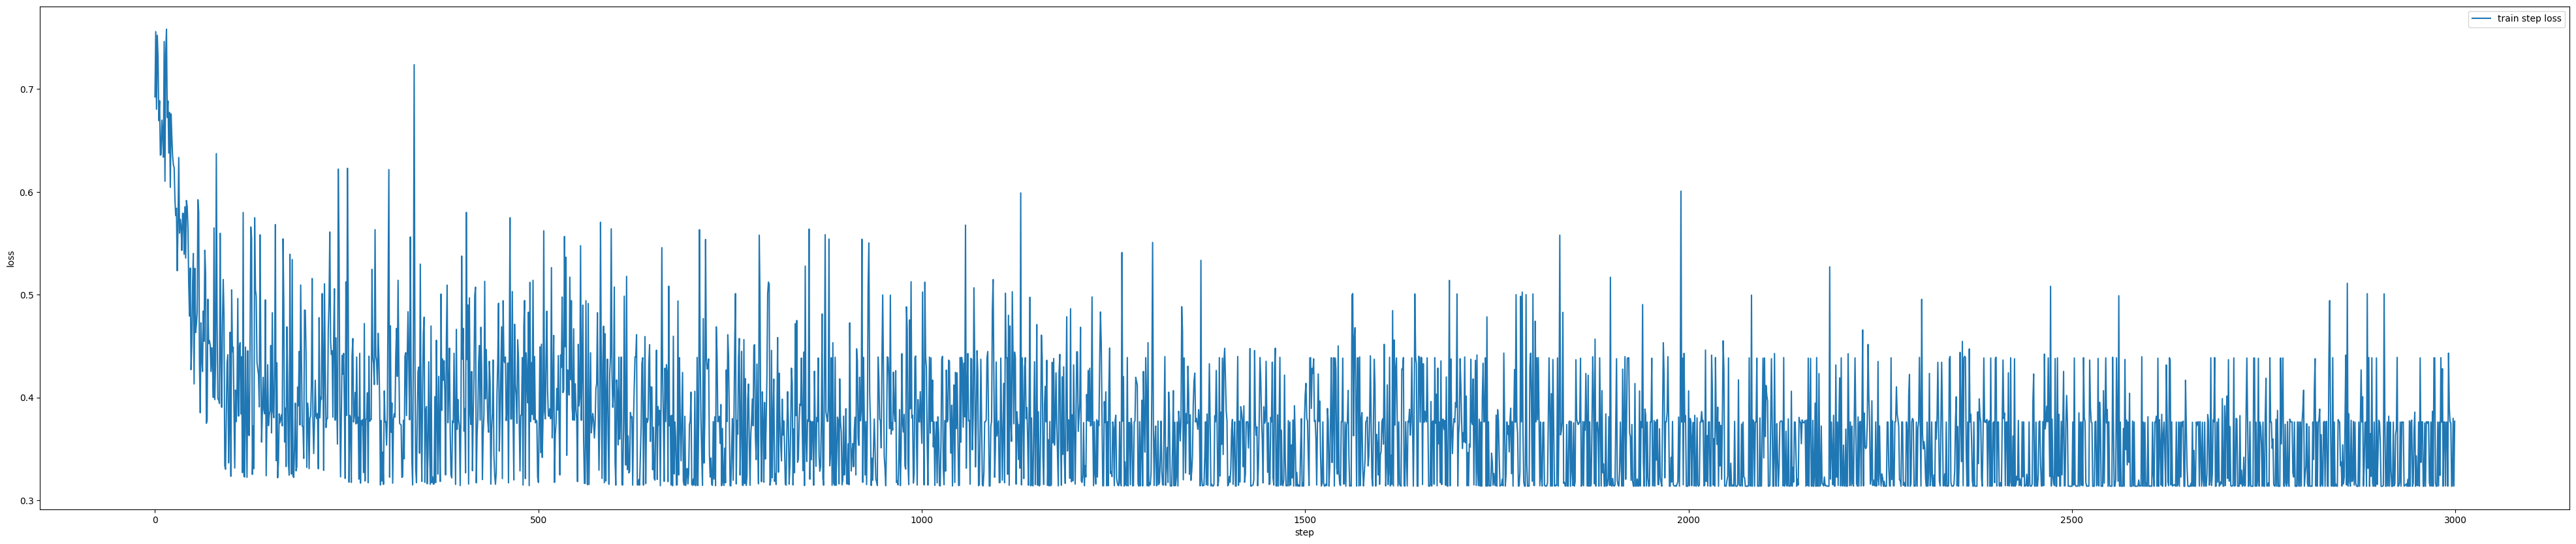

In [69]:
plt.figure(figsize=(50, 10))
plt.plot(train_step_loss_list, label='train step loss')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()
plt.show()

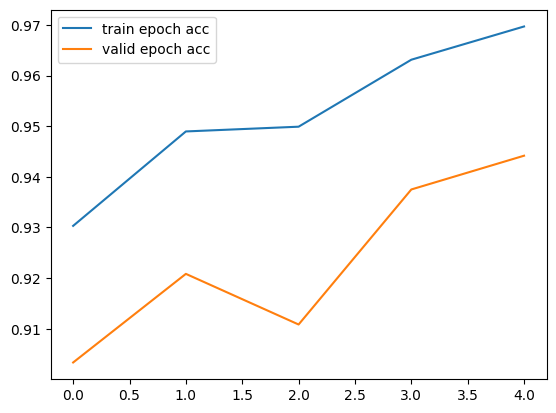

In [70]:
plt.plot(train_epoch_acc_list, label='train epoch acc')
plt.plot(valid_epoch_acc_list, label='valid epoch acc')
plt.legend()
plt.show()

In [71]:
model_best = Model(pretrained)
model_best.load_state_dict(best_model_state_dict[0])
model_best  # 最佳模型验证数据集的准确率对应的模型

Model(
  (fc): Linear(in_features=768, out_features=2, bias=True)
  (pretrained): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [72]:
model_best = model_best.to(device)
valid_acc_best = evaluate(model_best, dataloader_valid, device)
print(valid_acc_best)
print(best_valid_acc)  # 结果与上一致

0.9441666666666667
0.9441666666666667
